In [ ]:
from obspy import read

st = read("../Events_secstations/2014_01_04 00_11_50_M5_7/PATCX/PATCX_HL*.sac")

#st = read("../Events_secstations/2014_01_04 08_25_35_M3_7/PATCX/PATCX_HL*.sac")
st = read("../Events_secstations/2014_01_04 18_56_31_M3_6/PB05/PB05_HL*.sac")

# cargamos la Z
tr = st.select(component="Z")[0]
tr = tr.filter("bandpass", freqmin=1, freqmax=10)
# cortamos el efecto del filtro en los primeros 10 segundos
tr = tr.slice(tr.stats.starttime + 10, tr.stats.endtime)

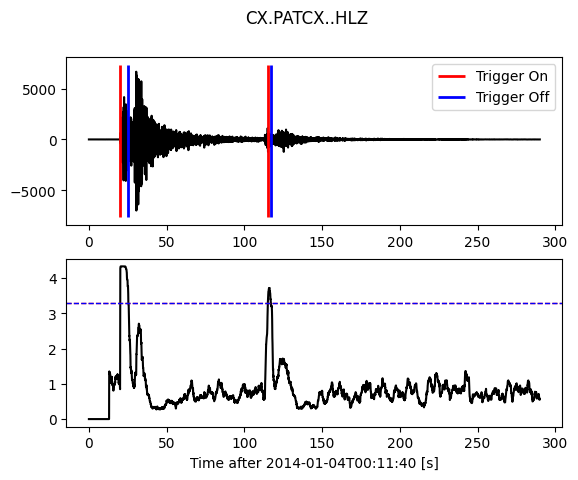

array([[ 2011,  2536],
       [11509, 11694]])

In [245]:
# trigger (HAY QUE TUNEAR PARA EL VOLCAN)
sta = 3*tr.stats.sampling_rate
lta = 13*tr.stats.sampling_rate
threshold = 3.3

from obspy.signal.trigger import classic_sta_lta, trigger_onset, plot_trigger
cft = classic_sta_lta(tr, sta, lta)
on_off = trigger_onset(cft, threshold, threshold)
plot_trigger(tr, cft, threshold, threshold)
on_off

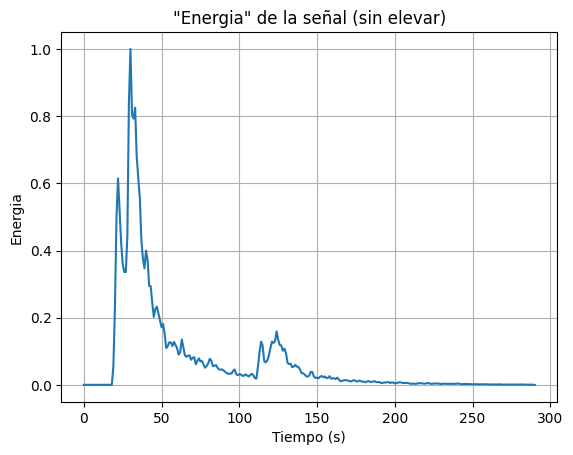

In [246]:
import numpy as np
import matplotlib.pyplot as plt
fs = 100
frame_len = 2
frame_shi = 1

def get_energy(signal, fs, frame_len, frame_shi):
    frame_len = int(fs * frame_len)
    frame_shi = int(fs * frame_shi)
    energy = []
    for i in range(0, len(signal), frame_shi):
        frame = signal[i:i+frame_len]
        energy.append(np.sum(np.abs(frame)))
    return energy/np.max(energy)

# plot energy
energy = get_energy(tr.data, fs, frame_len, frame_shi)

plt.plot(energy)
plt.title("\"Energia\" de la señal (sin elevar)")
plt.xlabel("Tiempo (s)")
plt.ylabel("Energia")
plt.grid()
plt.show()









20 0
115 99


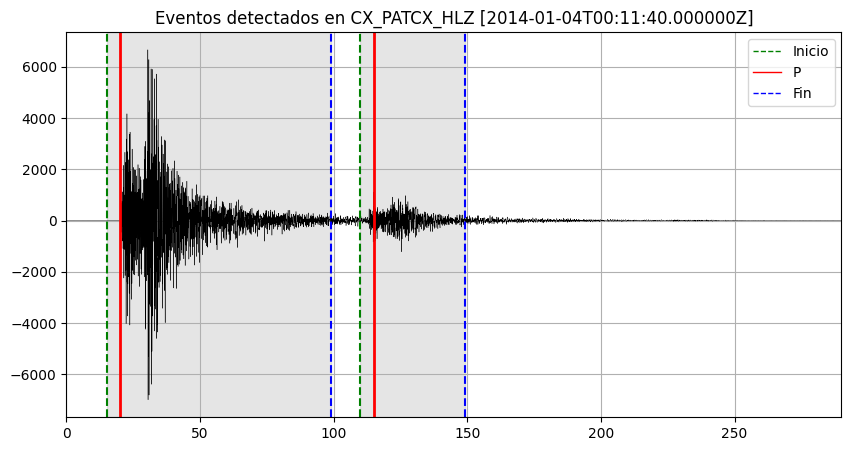

In [ ]:
def cut_events(trigger_list, trace_energy, event_offset, search_window=50, fs=100, end_energy=0.03):
    events = []
    last_event_end = 0
    for mark in trigger_list:
        start = int(mark[0]/fs)
        print(start, last_event_end)
        if start < last_event_end:
            continue
        energy = trace_energy[start-event_offset:start+search_window]
        n_max_energy = np.argmax(energy)
        n_min_energy = np.argmin(energy[:n_max_energy])
        delta = (energy[n_max_energy] - energy[n_min_energy]) * end_energy + energy[n_min_energy]
        n_delta = np.where(np.array(energy[n_max_energy:]) < delta)[0][0] + n_max_energy
        start_time = start-event_offset
        p_time = start
        end_time = n_delta + (start-event_offset)
        last_event_end = end_time
        events.append([start_time, p_time, end_time])
    return events

trace_energy = get_energy(tr.data, fs, frame_len, frame_shi)
# este igual habria q tunearlo para el volcan
events = cut_events(on_off, trace_energy, event_offset=5, search_window=100, fs=100, end_energy=0.03)
plt.figure(figsize=(10, 5))
plt.plot(tr.times(), tr.data, linewidth=0.3, color="k")
for event in events:
    start, p, end = event
    plt.axvline(start, color="g", linestyle="--")
    plt.axvline(p, color="r", linewidth=2)
    plt.axvline(end, color="b", linestyle="--")
    plt.axvspan(start, end, alpha=0.2, color="gray")
plt.axvline(-1, color="g", linewidth=1, linestyle="--", label="Inicio")
plt.axvline(-1, color="r", linewidth=1, label="P")
plt.axvline(-1, color="b", linewidth=1, linestyle="--", label="Fin")
plt.xlim(0, len(tr.data)/fs)
plt.legend()
plt.grid()
plt.title(f"Eventos detectados en {tr.stats.network}_{tr.stats.station}_{tr.stats.channel} [{tr.stats.starttime}]")
plt.show()
    
